# NYC Home Ownership vs. Rental Cost Comparison

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import ticker

from nyc_home_cost_calculator.home import FilingStatus, NYCHomeCostCalculator
from nyc_home_cost_calculator.investment import InvestmentCalculator
from nyc_home_cost_calculator.rent import NYCRentalCostCalculator
from nyc_home_cost_calculator.utils import calculate_confidence_intervals

In [2]:
import warnings

warnings.filterwarnings("error")

In [3]:
# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("deep")

In [4]:
# Set random seed for reproducibility
rng = np.random.default_rng(1337)

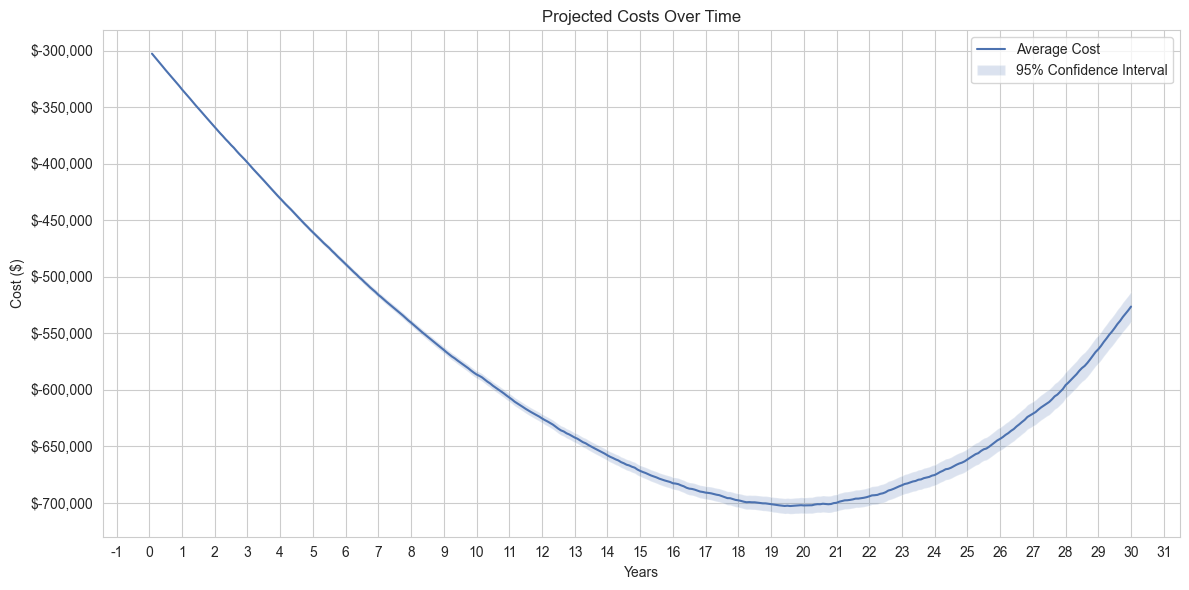

In [5]:
# Initialize calculators with default parameters
home_price = 1_000_000.0
down_payment = home_price * 0.20

home_calculator = NYCHomeCostCalculator(
    home_price=home_price,
    down_payment=down_payment,
    mortgage_rate=0.05,
    loan_term=30,
    initial_income=200_000.0,
    hoa_fee=500.0,
    insurance_rate=0.005,
    maintenance_rate=0.01,
    property_tax_rate=0.01,
    mean_appreciation_rate=0.03,
    appreciation_volatility=0.1,
    mean_inflation_rate=0.02,
    inflation_volatility=0.015,
    mean_income_change_rate=0.03,
    income_change_volatility=0.02,
    retirement_contribution_rate=0.15,
    filing_status=FilingStatus.SINGLE,
    extra_payment=0.0,
    extra_payment_start_year=1,
    extra_payment_end_year=30,
    purchase_closing_cost_rate=0.03,
    sale_closing_cost_rate=0.07,
    marriage_probability=0.05,
    divorce_probability=0.02,
    partner_income_ratio=1.0,
    simulations=10_000,
    rng=rng,
)

# Run simulation
home_results = home_calculator.simulate()

# Plot the results
home_calculator.plot(home_results.profit_loss)

# Save the results to an Excel spreadsheet
home_calculator.export_to_excel("home-costs.xlsx", home_results.profit_loss)

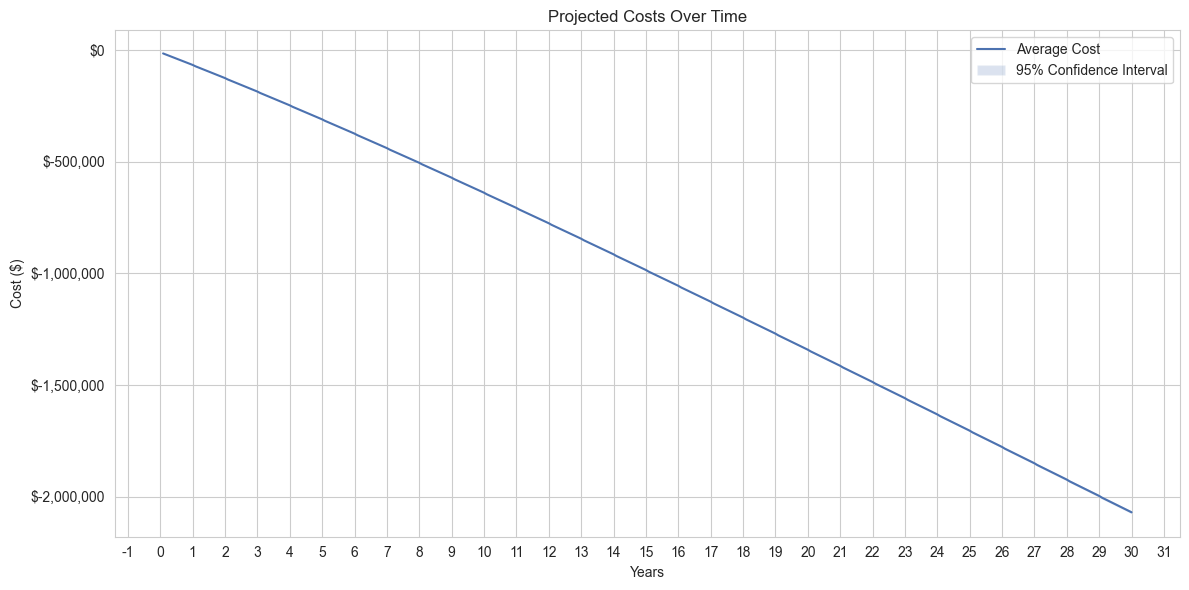

In [6]:
rental_calculator = NYCRentalCostCalculator(
    initial_rent=4_500.0,
    lease_term=1.0,
    total_years=30,  # Match the home ownership term
    utility_cost=100.0,
    renters_insurance=300.0,
    moving_cost=2_500.0,
    mean_rent_increase_rate=0.03,
    rent_increase_volatility=0.025,
    mean_inflation_rate=0.02,
    inflation_volatility=0.015,
    broker_fee_rate=0.15,
    move_probability=0.1,
    rent_increase_move_threshold=0.1,
    simulations=10_000,
    rng=rng,
)

# Run simulation
rent_results = rental_calculator.simulate()

# Plot the results
rental_calculator.plot(rent_results.profit_loss)

# Save the results to an Excel spreadsheet
rental_calculator.export_to_excel("rental-costs.xlsx", rent_results.profit_loss)

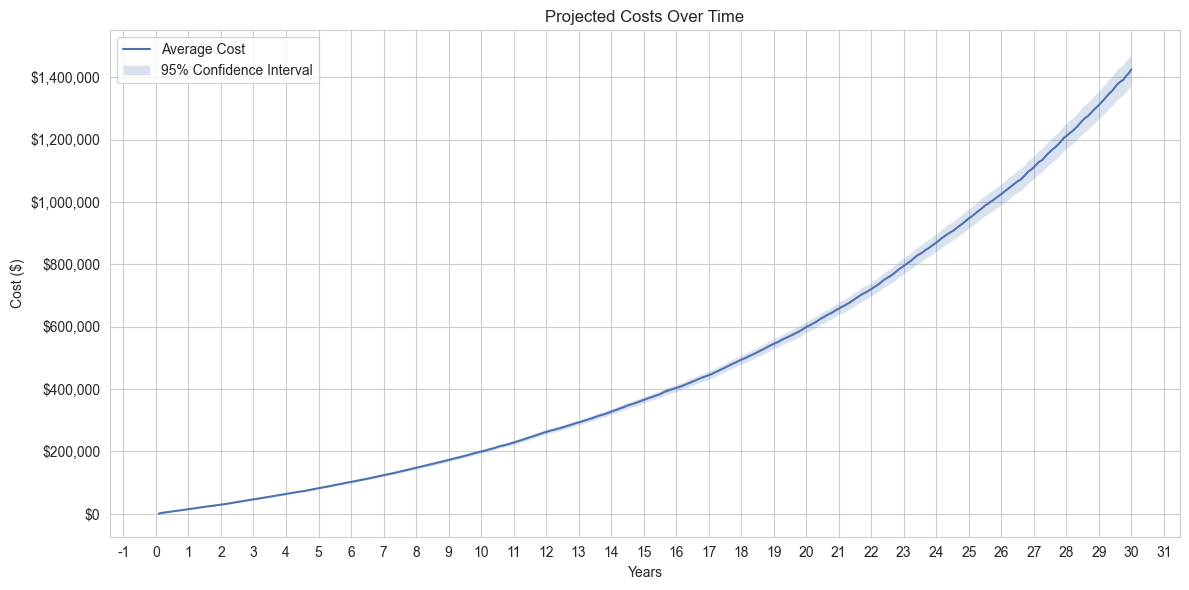

In [7]:
investment_calculator = InvestmentCalculator(
    initial_investment=down_payment,
    monthly_contribution=0.0,
    total_years=30,
    mean_return_rate=0.07,
    volatility=0.15,
    degrees_of_freedom=4,
    simulations=10_000,
    rng=rng,
)


# Run simulation
investment_results = investment_calculator.simulate()

# Plot the results
investment_calculator.plot(
    investment_results.profit_loss,
    title="Investment Value Over Time",
    ylabel="Investment Value ($)",
    label="Average Investment Value",
)

# Save the results to an Excel spreadsheet
investment_calculator.export_to_excel("investment-costs.xlsx", investment_results.profit_loss)

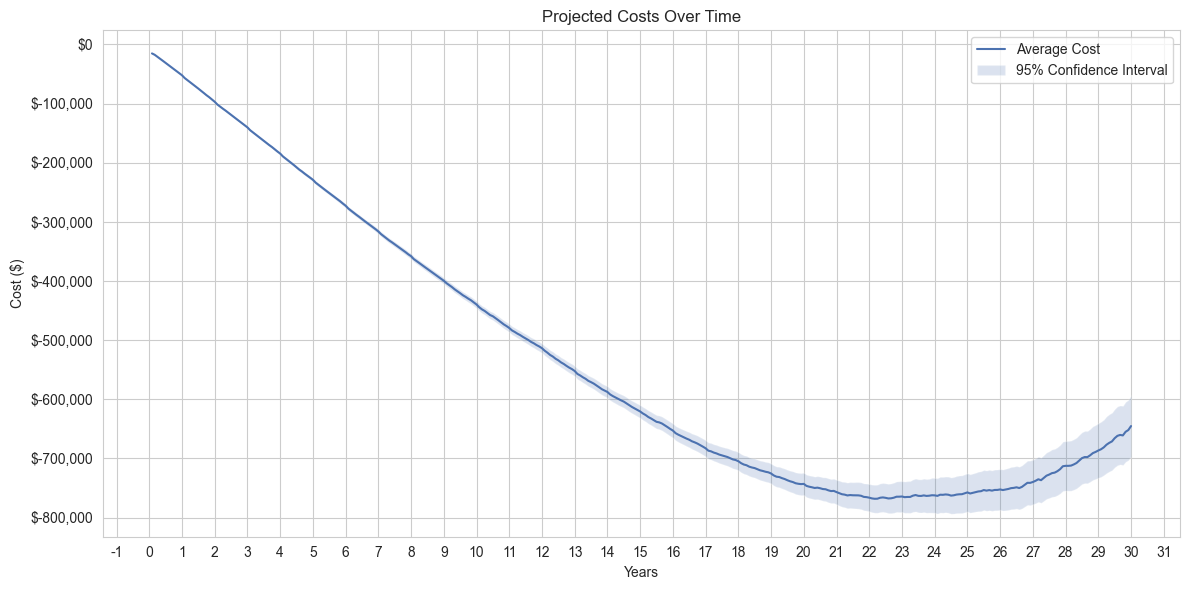

In [8]:
# Combine the rent results and investment results to compare with home ownership with rent + investment.
rent_and_investment_results = rent_results + investment_results

# Plot the results
rental_calculator.plot(rent_and_investment_results.profit_loss)

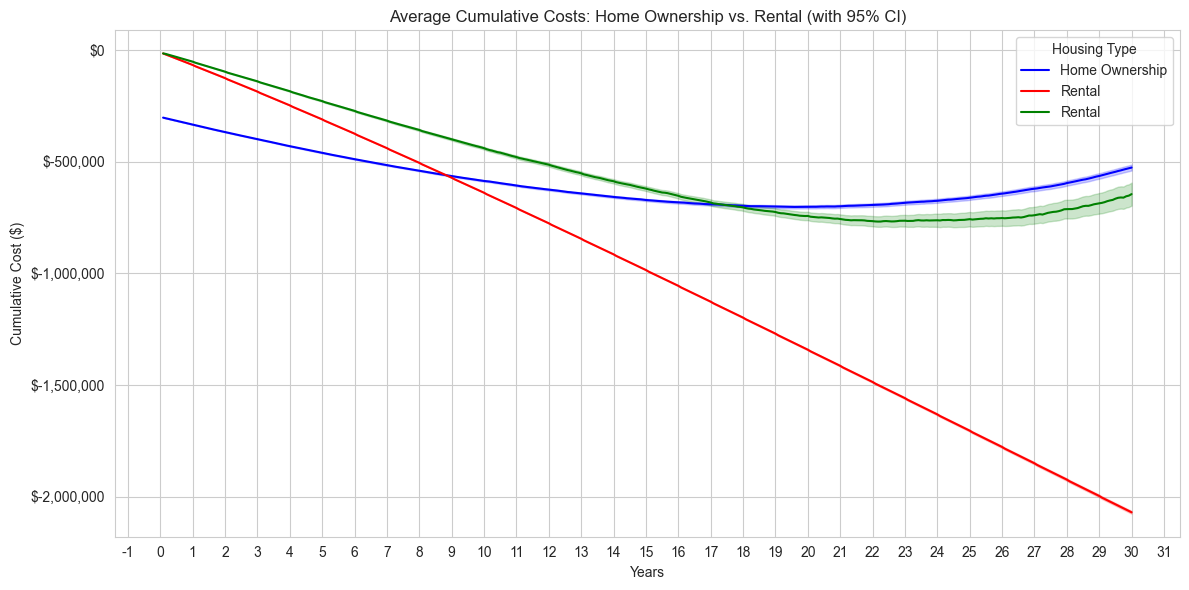

In [9]:
# Prepare data for plotting
years = np.array(list(range(1, (12 * 30) + 1))) / 12

# Calculate statistics for home ownership and rental
home_means, home_ci_lower, home_ci_upper = calculate_confidence_intervals(home_results.profit_loss)
rental_means, rental_ci_lower, rental_ci_upper = calculate_confidence_intervals(rent_results.profit_loss)
rai_means, rai_ci_lower, rai_ci_upper = calculate_confidence_intervals(rent_and_investment_results.profit_loss)

# Plot average costs over time with confidence intervals
plt.figure(figsize=(12, 6))

# Plot home ownership data
plt.plot(years, home_means, label="Home Ownership", color="blue")
plt.fill_between(years, home_ci_lower, home_ci_upper, alpha=0.2, color="blue")

# Plot rental data
plt.plot(years, rental_means, label="Rental", color="red")
plt.fill_between(years, rental_ci_lower, rental_ci_upper, alpha=0.2, color="red")

# Plot rental + investment data
plt.plot(years, rai_means, label="Rental + Investment", color="green")
plt.fill_between(years, rai_ci_lower, rai_ci_upper, alpha=0.2, color="green")

plt.title("Average Cumulative Costs: Home Ownership vs. Rental (with 95% CI)")
plt.xlabel("Years")
plt.ylabel("Cumulative Cost ($)")
plt.legend(title="Housing Type")

# Format axes
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

plt.tight_layout()
plt.show()

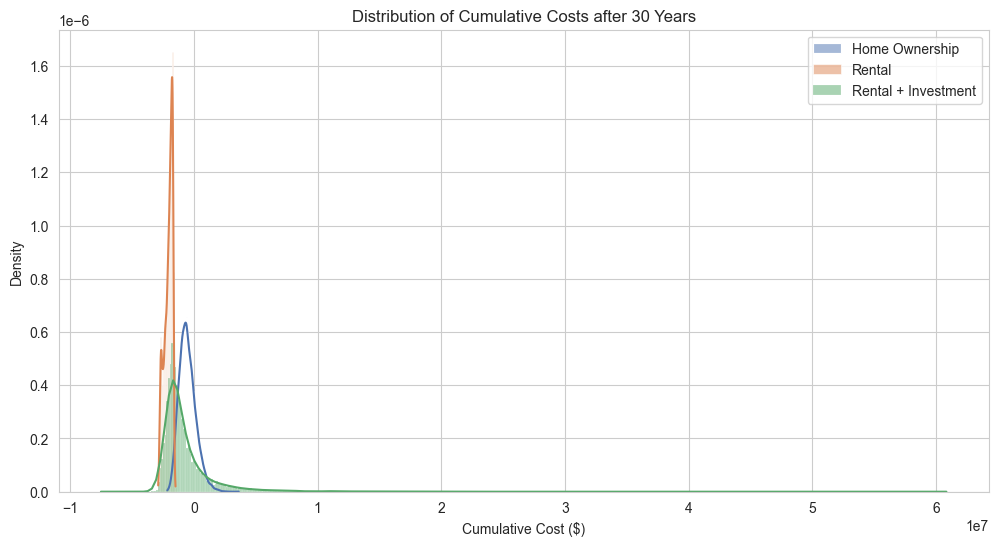

In [10]:
# Calculate and plot cost distribution for the final month
home_final_month = home_results.profit_loss[-1]
rental_final_month = rent_results.profit_loss[-1]
rai_final_month = rent_and_investment_results.profit_loss[-1]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(home_final_month, kde=True, stat="density", label="Home Ownership", ax=ax)
sns.histplot(rental_final_month, kde=True, stat="density", label="Rental", ax=ax)
sns.histplot(rai_final_month, kde=True, stat="density", label="Rental + Investment", ax=ax)
plt.title("Distribution of Cumulative Costs after 30 Years")
plt.xlabel("Cumulative Cost ($)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [11]:
# Calculate and print summary statistics
home_stats = home_calculator.get_cost_statistics(home_results.profit_loss)
rental_stats = rental_calculator.get_cost_statistics(rent_and_investment_results.profit_loss)

print("Home Ownership Statistics:")
for stat, value in home_stats.items():
    print(f"{stat.capitalize()}: ${value:,.2f}")

print("\nRental Statistics:")
for stat, value in rental_stats.items():
    print(f"{stat.capitalize()}: ${value:,.2f}")

Home Ownership Statistics:
Mean: $-526,449.13
Median: $-598,505.96
Std_dev: $671,441.76
Percentile_5: $-1,495,034.33
Percentile_95: $677,475.90

Rental Statistics:
Mean: $-645,361.54
Median: $-1,363,765.16
Std_dev: $2,629,791.46
Percentile_5: $-2,433,662.24
Percentile_95: $3,282,334.47


In [12]:
msg = "Based on the given parameters and simulations, "
if home_stats["mean"] > rental_stats["mean"]:
    msg += "homeownership appears to be more cost-effective in the long run.\n"
else:
    msg += "renting appears to be more cost-effective in the long run.\n"
msg += "However, this conclusion is highly dependent on the input parameters and individual circumstances.\n"
print(msg)

Based on the given parameters and simulations, homeownership appears to be more cost-effective in the long run.
However, this conclusion is highly dependent on the input parameters and individual circumstances.

